# <center>FONCTION CARTOGRAPHIE</center> #

## <font color='#5BA69E'>INTRODUCTION</font> ##

Ce notebook a pour objectif de réaliser de multiples cartographies pour une variable de l'INSEE à définir par l'utilisateur.  
Le cadre est limité à la France métropolitaine et les DOM TOM sont donc exclus.

L'utilisateur doit disposer d'un fichier csv avec la ou les variables qu'il souhaite cartographier.  
Le fichier doit obligatoirement contenir la variable CODGEO au format 'string'.

## <font color='#5BA69E'>INSTRUCTIONS</font> ##

Commencez par déposer votre fichier csv dans le répertoire **files** (que l'on trouve dans cette branche de github) puis renseignez le nom de fichier dans la variable ci-dessous. 

In [1]:
nom_dataset = 'TP6020.csv'

Définissez la variable cible de votre dataset à cartographier (ex: salaire médian, nombre d'établissements.)

In [2]:
nom_variable = 'TP6020'

Définissez une aire d'attraction de ville comme focus.

In [3]:
aire_attraction = 'Lille (partie française)'

Définissez le nom de la ville principale de la ville d'attraction (les noms peuvent différer comme pour Lille)

In [4]:
ville_principale = 'Lille'

Définir le titre des graphiques en fonction de la variable sélectionnée (et indépendament des zones géographiques qui s'afficheront pour chaque graphique dans le titre)

In [5]:
titre = "Indicateur de pauvreté"

Donnez le nom souhaité pour l'aire d'attraction indiqué en titre de la cartographie

In [6]:
titre_ville = 'Lille'

Pour les cartographies par région, département et aires d'attraction des villes, il est nécessaire de définir de quelle manière on souhaite aggréger les données (exemple si l'on souhaite connaître le nombre d'établissement par zone géographique, on choisira 'sum' pour avoir la somme des établissements par région, département, ville).  

A préciser dans la variable ci-dessous :

In [7]:
aggfunc = 'mean'

In [8]:
titre_legende = "Taux de pauvreté (%)"

## <font color='#5BA69E'>IMPORT LIBRAIRIES</font> ##

In [9]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns

#élargissement de la visualisation des tableaux pandas
pd.set_option('display.max_columns', None)

#suppression des warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
gdf = geopandas.read_file('../files/fond_AAV2020_geo20_metro/zMetro.shp')

## <font color='#5BA69E'>CHARTE GRAPHIQUE</font> ##

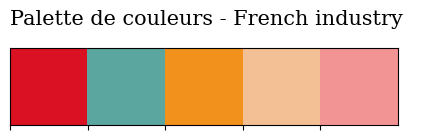

In [11]:
sns.palplot(["#D91122", "#5BA69E", "#F2911B", "#F2C094", "#F29494"])
plt.title("Palette de couleurs - French industry  ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

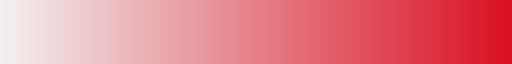

In [12]:
pal = sns.light_palette("#D91122", input='rgb', as_cmap=True, n_colors=10)
pal


## <font color='#5BA69E'>FONCTION</font> ##

In [13]:
def carto_french_indus(nom_dataset, nom_variable, aire_attraction, ville_principale, titre, titre_ville, aggfunc, titre_legende):
    #import fichier shapefile pour réaliser les fonds de cartes
    gdf = geopandas.read_file('../files/fond_AAV2020_geo20_metro/zMetro.shp')
    
    #import du csv donnée en argument de la fonction
    data = pd.read_csv('../files/'+nom_dataset, dtype={'CODGEO': 'string'})
    
    #import du nom des régions et création d'un dictionnaire pour des besoins de mapping
    regions = pd.read_csv('../files/region2020.csv', dtype={'reg': 'string'})
    regions_dict = dict(list(zip(regions.reg, regions.libelle)))
    
    #import du nom des départements et création d'un dictionnaire pour des besoins de mapping
    dep = pd.read_csv('../files/departement2020.csv')
    dep_dict = dict(list(zip(dep.dep, dep.dep)))
    
    #import des aires d'attraction des villes et création d'un dictionnaire pour des besoins de mapping
    aav = pd.read_csv('../files/AAV20.csv', sep=';')
    aav_dict = dict(list(zip(aav.AAV2020, aav.LIBAAV2020)))
    
    #import de la population par commune pour pondérer les aggrégations par région et par département
    #population = pd.read_csv('../files/pop_par_codgeo.csv')
    
    invalid_codgeo_list = []
    invalid_codgeo = 0
    for codgeo in data.CODGEO:
        if len(codgeo) != 5:
            invalid_codgeo += 1
            invalid_codgeo_list.append(codgeo)
    print('Nombre de CODGEO invalides (pas au format string ou pas 5 caractères) :', invalid_codgeo)
    print('Liste des CODGEO posant problème :', invalid_codgeo_list)
    
    data = data[['CODGEO', nom_variable]]
    gdf_data = gdf.merge(data, how='left', on='CODGEO')
    #gdf_data = gdf_data.merge(population, how='left', on='CODGEO')
    print('Après le merge avec le fond de carte,', nom_variable, 'contient', gdf_data[nom_variable].isna().sum(), 'manquants')
    taux_manquant = np.round(gdf_data[nom_variable].isna().sum() / len(gdf_data) * 100,2)
    print('Taux de manquant :', taux_manquant, '%')
    print('Extrait des manquants identifiés :')
    display(gdf_data[gdf_data[nom_variable].isna()].head())

    #aggregation de la colonne geometry par REG
    gdf_data_reg = gdf_data.dissolve(by='REG', aggfunc=aggfunc)
    gdf_data_reg['REG_label'] = gdf_data_reg.index.map(regions_dict)
    
    #aggregation de la colonne geometry par DEP
    gdf_data_dep = gdf_data.dissolve(by='DEP', aggfunc=aggfunc)
    gdf_data_dep['DEP_label'] = gdf_data_dep.index.map(dep_dict) 
    
    #aggregation de la colonne geometry par aires d'attraction des villes
    gdf_data_aav = gdf_data[gdf_data.LIBAAV2 == aire_attraction].reset_index(drop=True)
    gdf_data_ville = gdf_data_aav[gdf_data_aav.LIBGEO == ville_principale].reset_index(drop=True)
    gdf_data_suburbs = gdf_data_aav[gdf_data_aav.LIBGEO != aire_attraction].reset_index(drop=True)
    gdf_data_suburbs.to_csv('lille.csv')
    #gdf_data_suburbs = gdf_data_aav[gdf_data_aav.LIBGEO == aire_attraction].reset_index(drop=True)
    
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  REGIONS  XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    

    fig, ax = plt.subplots(figsize=(30,30))
    
    #Ajout d'une variable coords pour mapper les labels sur les zone géographiques
    gdf_data_reg['coords'] = gdf_data_reg['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf_data_reg['coords'] = [coords[0] for coords in gdf_data_reg['coords']]
    
    #Création de la cartographie
    gdf_data_reg.plot( ax=ax,
                     column=nom_variable,
                     edgecolor='#565656',
                     cmap=pal,
                     legend=True,
                     legend_kwds={'shrink': 0.7}
                    )
    #Ajout des labels sur les zones géographiques
    for idx, row in gdf_data_reg.iterrows():
        plt.annotate(text=row['REG_label'], xy=row['coords'],
                     horizontalalignment='center', fontname='sans-serif', fontsize=14 )

    #Optimisation de la cartographie
    plt.title(titre + ' ' + 'par région \n', fontsize=48, fontname='sans-serif')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    jauge = fig.axes[1]
    jauge.tick_params(labelsize=20)
    plt.show()
    
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  DEPARTEMENTS  XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    
    fig, ax = plt.subplots(figsize=(30,30))
    
    #Ajout d'une variable coords pour mapper les labels sur les zone géographiques
    gdf_data_dep['coords'] = gdf_data_dep['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf_data_dep['coords'] = [coords[0] for coords in gdf_data_dep['coords']]
    
    #Création de la cartographie
    gdf_data_dep.plot( ax=ax,
                     column=nom_variable,
                     edgecolor='#565656',
                     cmap=pal,
                     legend=True,
                     legend_kwds={'shrink': 0.7}
                    )
    #Ajout des labels sur les zones géographiques
    for idx, row in gdf_data_dep.iterrows():
        if row['DEP_label'] in ['75', '92', '93', '94']:
            continue
        else:
            plt.annotate(text=row['DEP_label'], 
                         xy=row['coords'], 
                         horizontalalignment='center', 
                         fontname='sans-serif', 
                         fontsize=12 )

    #Optimisation de la cartographie
    plt.title(titre + ' ' + 'par département \n', fontsize=48, fontname='sans-serif')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    jauge = fig.axes[1]
    jauge.tick_params(labelsize=20)
    plt.show()    

    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  AIRE D'ATTRACTION DES VILLES  XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX  
    #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
    
    fig, ax = plt.subplots(figsize=(30,30))
    
    #Ajout d'une variable coords pour mapper les labels sur les zone géographiques
    gdf_data_suburbs['coords'] = gdf_data_suburbs['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf_data_suburbs['coords'] = [coords[0] for coords in gdf_data_suburbs['coords']]
    
    #Création de la cartographie
    gdf_data_suburbs.plot( ax=ax,
                     column=nom_variable,
                     edgecolor='#565656',
                     cmap=pal,
                     legend=True,
                     legend_kwds={'label': titre_legende, 
                                  'shrink': 0.7,
                                  }
                     #legend_kwds={'shrink': 0.7}
                    )
    
    
    #Ajout des labels sur les zones géographiques
    top_10 = gdf_data_suburbs.sort_values(by=nom_variable, ascending=False).head(10)
    #for idx, row in gdf_data_suburbs.iterrows():
    for idx, row in top_10.iterrows():
        plt.annotate(text=row['LIBGEO'], 
                        xy=row['coords'], 
                        horizontalalignment='center', 
                        fontname='sans-serif', 
                        fontsize=9 )
        
    #Ajout des labels sur les zones géographiques
    flop_10 = gdf_data_suburbs.sort_values(by=nom_variable, ascending=True).head(10)
    #for idx, row in gdf_data_suburbs.iterrows():
    for idx, row in flop_10.iterrows():
        plt.annotate(text=row['LIBGEO'], 
                        xy=row['coords'], 
                        horizontalalignment='center', 
                        fontname='sans-serif', 
                        fontsize=9 )
    
    
    #Ajout d'une variable coords pour mapper les labels sur les zone géographiques
    gdf_data_ville['coords'] = gdf_data_ville['geometry'].apply(lambda x: x.representative_point().coords[:])
    gdf_data_ville['coords'] = [coords[0] for coords in gdf_data_ville['coords']]
        
    gdf_data_ville.plot( 
                ax=ax,
                color='#5BA69E',
                alpha=0.8
               )
    """
    #Ajout des labels sur les zones géographiques
    for idx, row in gdf_data_ville.iterrows():
        plt.annotate(text=row['LIBGEO'], 
                        xy=row['coords'], 
                        horizontalalignment='center', 
                        fontname='sans-serif', 
                        fontsize=18 )
    """
    
    #Optimisation de la cartographie
    plt.title(titre + ' - ' + titre_ville + '\n', fontsize=48, fontname='sans-serif')
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    jauge = fig.axes[1]
    jauge.tick_params(labelsize=20)
    plt.show()
    
    print("L'aire d'attraction")
    display(gdf_data_ville[['LIBGEO', nom_variable]])
    print("Top 10 des communes de l'aire d'attraction")
    display(gdf_data_suburbs[['LIBGEO', nom_variable]].sort_values(by=nom_variable, ascending=False).head(10).reset_index(drop=True))
    print("Flop 10 des communes de l'aire d'attraction")
    display(gdf_data_suburbs[['LIBGEO', nom_variable]].sort_values(by=nom_variable, ascending=True).head(10).reset_index(drop=True))

Nombre de CODGEO invalides (pas au format string ou pas 5 caractères) : 0
Liste des CODGEO posant problème : []
Après le merge avec le fond de carte, TP6020 contient 30565 manquants
Taux de manquant : 87.73 %
Extrait des manquants identifiés :


,REG,DEP,CODGEO,LIBGEO,AAV20,LIBAAV2,CATEAAV,LIBCATE,TAAV20,LIBTAAV,geometry,TP6020
0,84,01,01001,L'Abergement-Clémenciat,524,Châtillon-sur-Chalaronne,20,Commune de la couronne,1,Aire de moins de 50 000 habitants,"POLYGON ((848739.984 6559620.025, 848407.995 6...",NaN
1,84,01,01002,L'Abergement-de-Varey,000,Commune hors attraction des pôles,30,Commune hors attraction des pôles,0,Commune hors attraction des pôles,"POLYGON ((888100.970 6545454.035, 887680.027 6...",NaN
3,84,01,01005,Ambérieux-en-Dombes,002,Lyon,20,Commune de la couronne,4,Aire de 700 000 habitants ou plus (hors Paris),"POLYGON ((846743.971 6544005.021, 845594.948 6...",NaN
4,84,01,01006,Ambléon,286,Belley,20,Commune de la couronne,1,Aire de moins de 50 000 habitants,"POLYGON ((903310.008 6518371.949, 902936.946 6...",NaN
6,84,01,01008,Ambutrix,243,Ambérieu-en-Bugey,20,Commune de la couronne,1,Aire de moins de 50 000 habitants,"POLYGON ((879933.000 6538496.020, 878927.960 6...",NaN


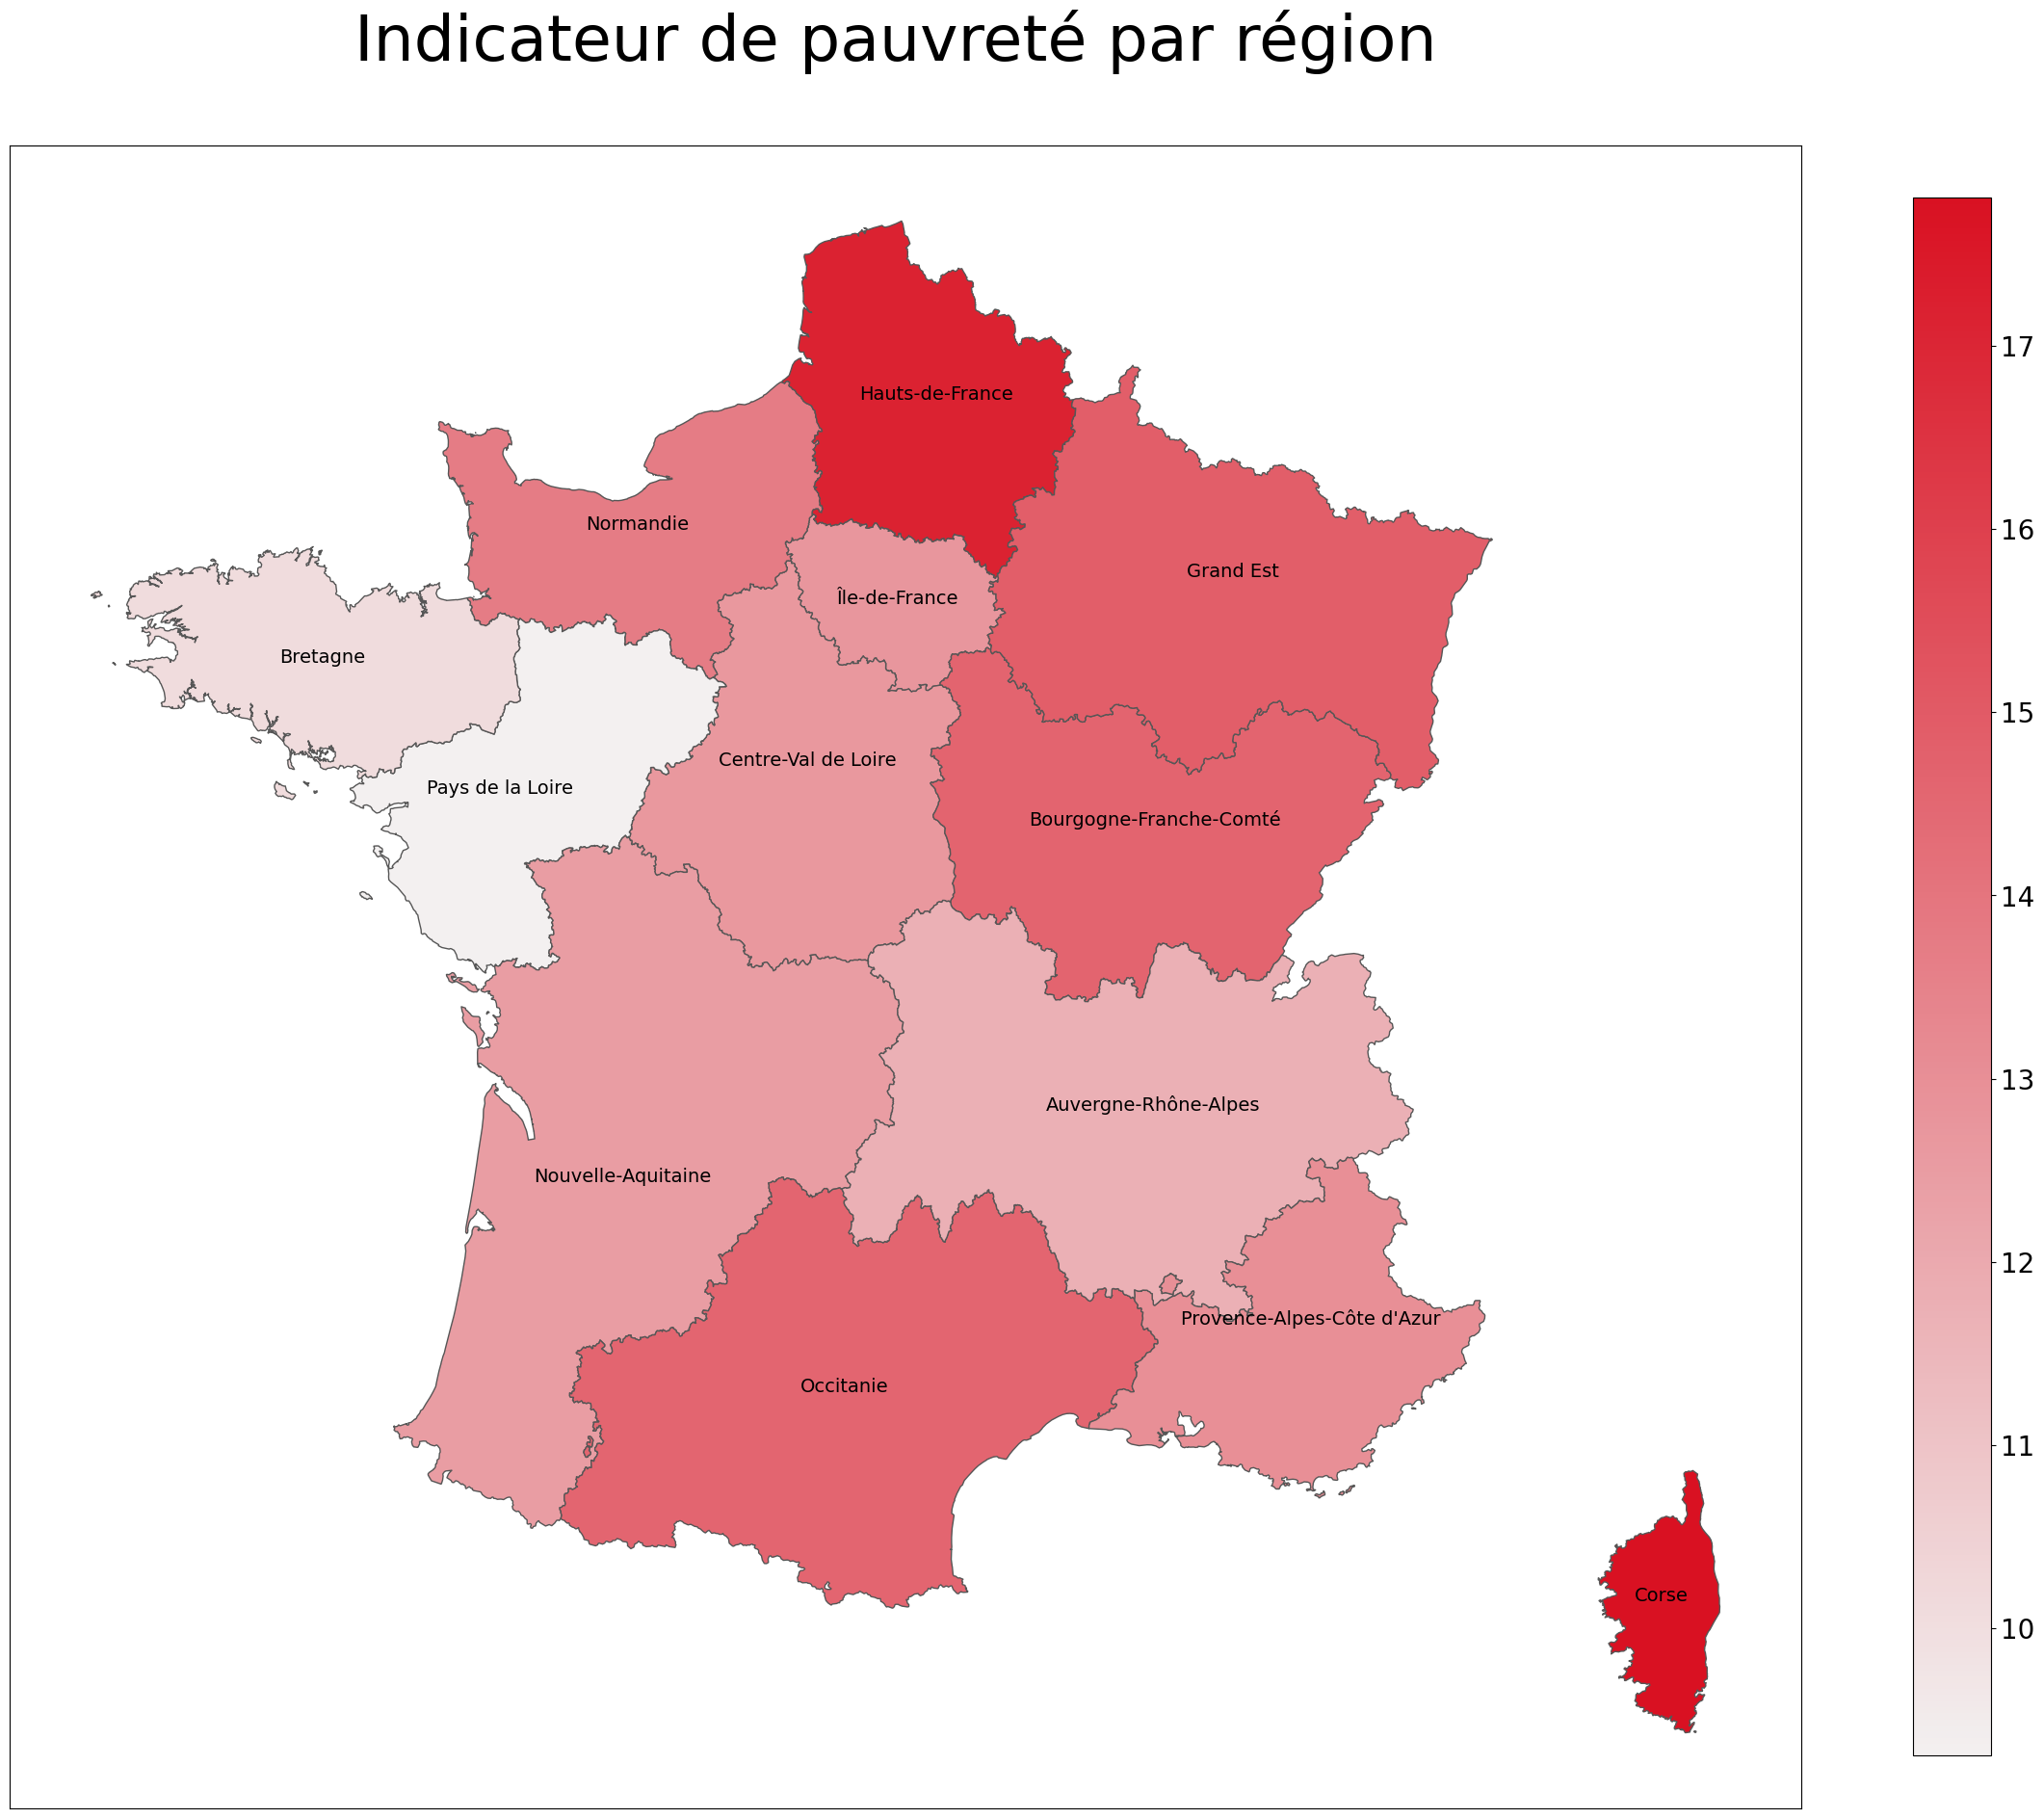

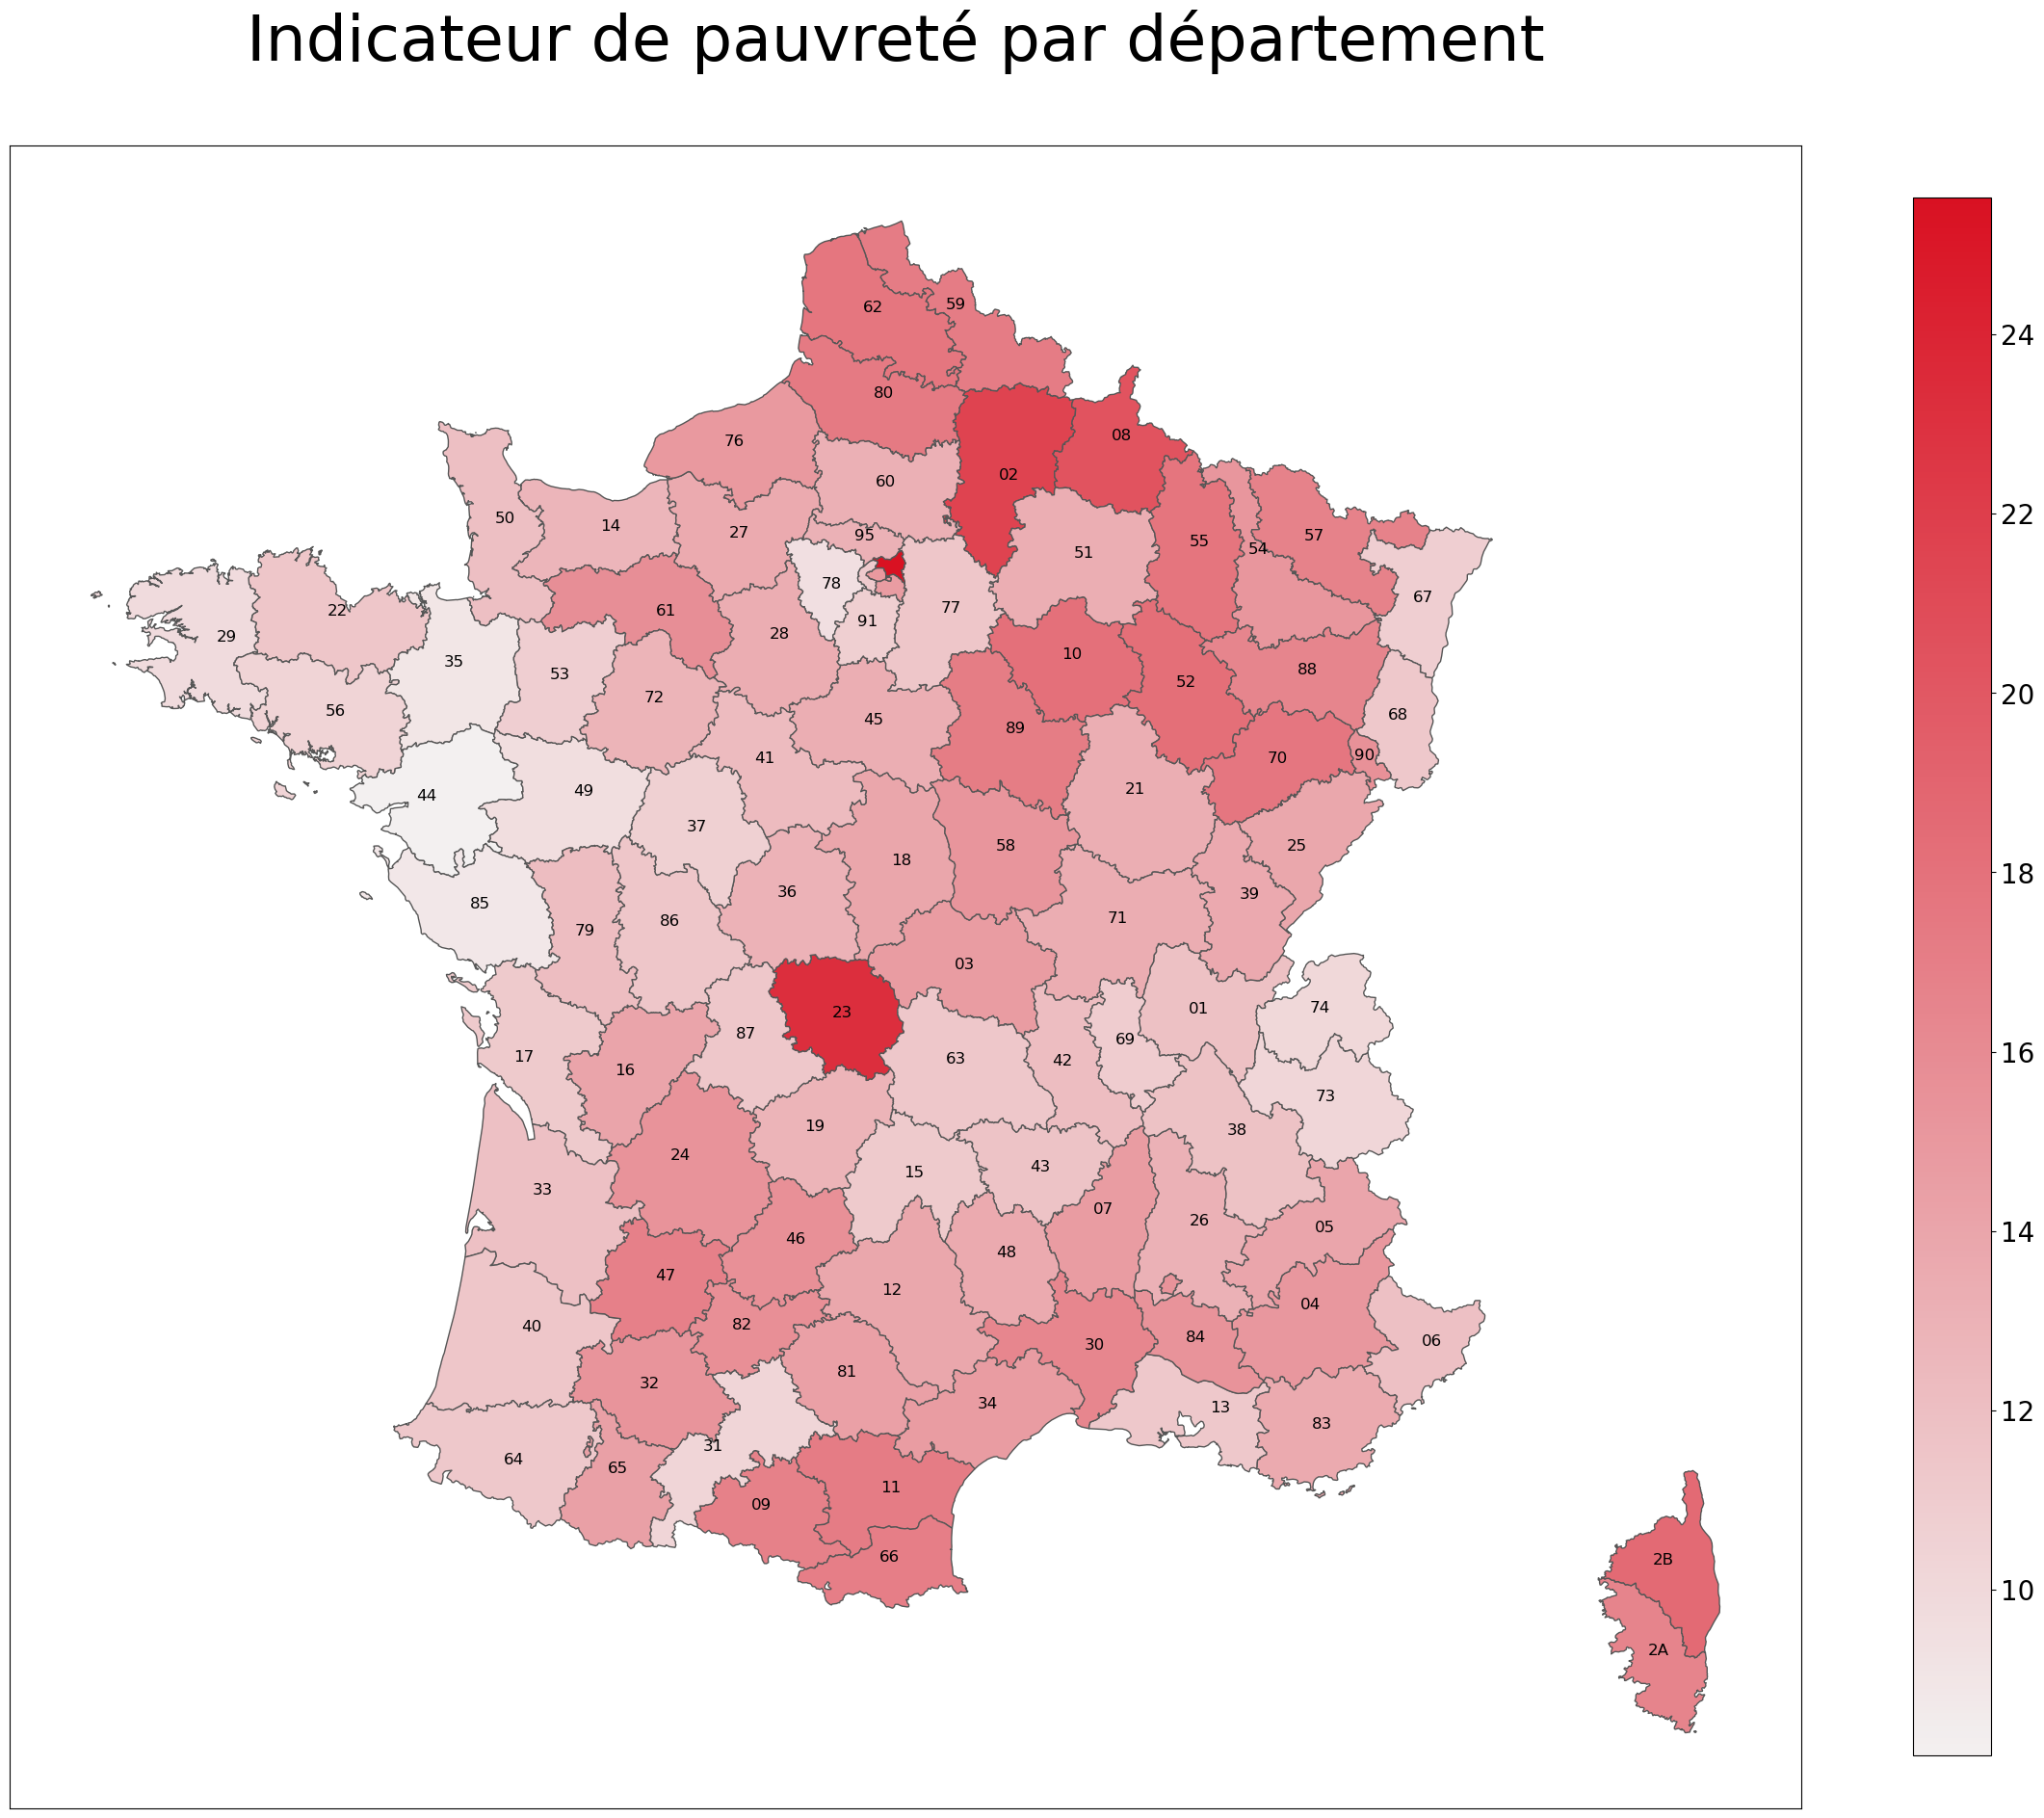

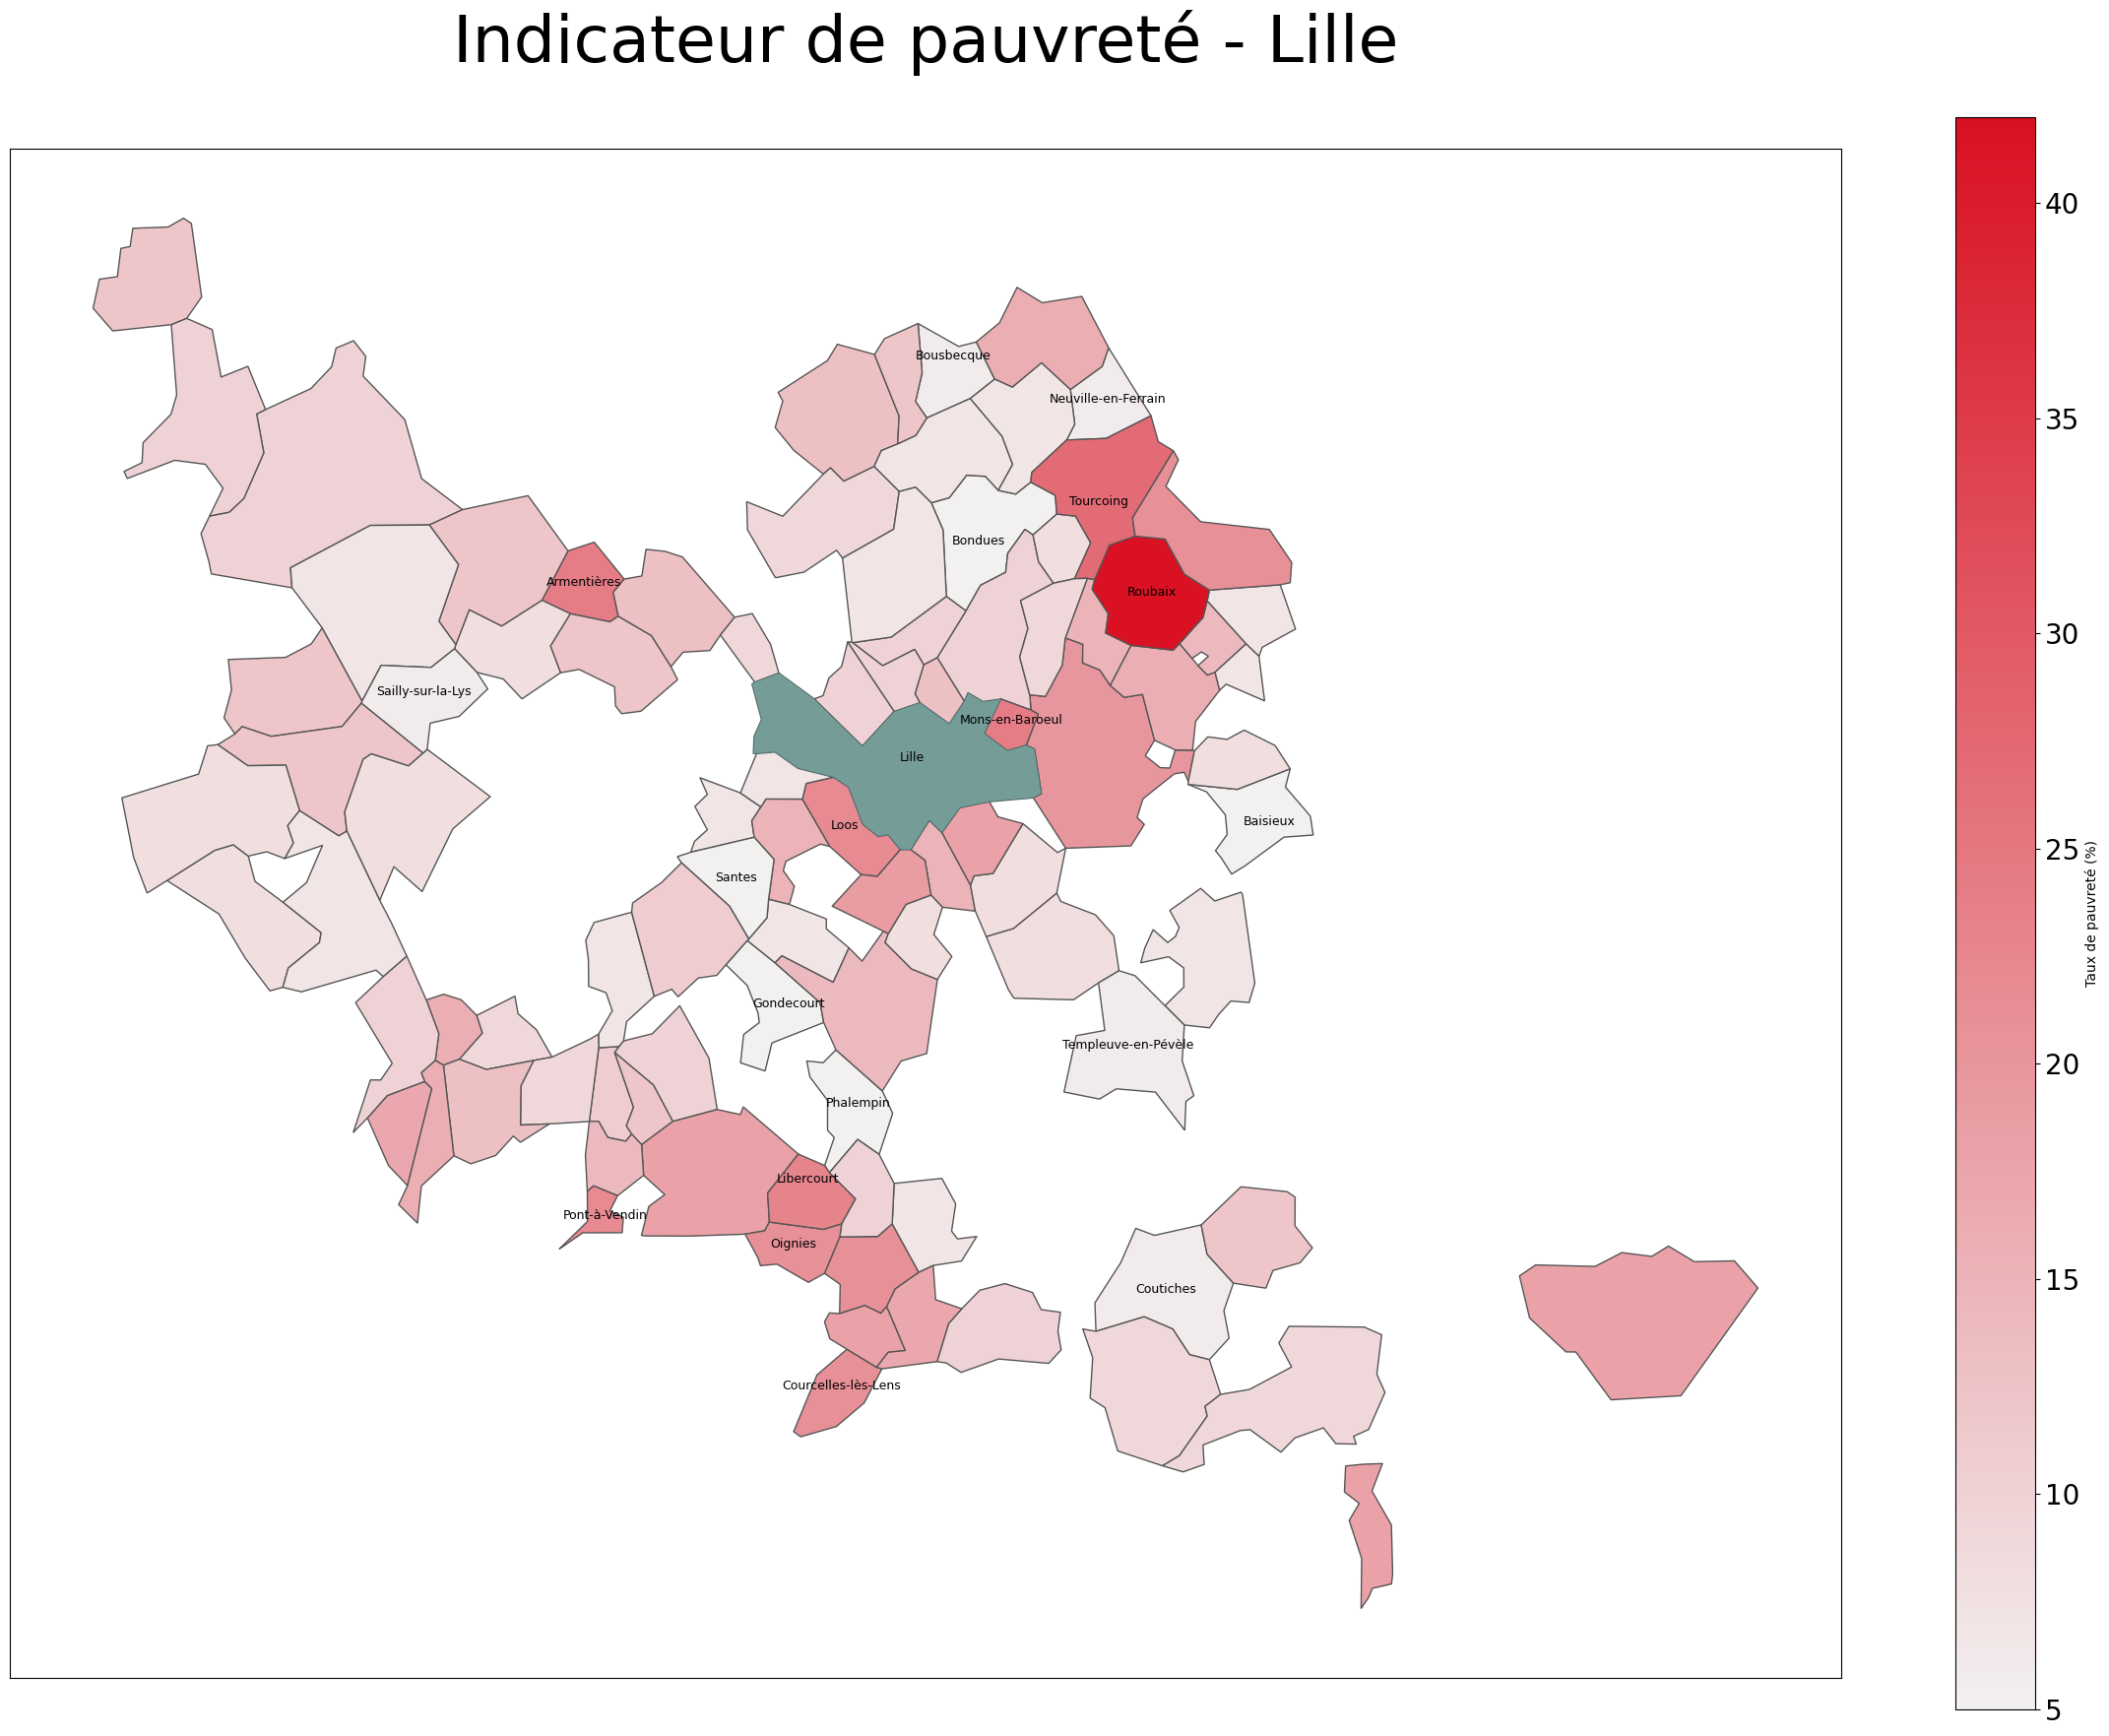

L'aire d'attraction


,LIBGEO,TP6020
0,Lille,25.0


Top 10 des communes de l'aire d'attraction


,LIBGEO,TP6020
0,Roubaix,42.0
1,Tourcoing,27.0
2,Lille,25.0
3,Armentières,24.0
4,Mons-en-Baroeul,24.0
5,Libercourt,23.0
6,Pont-à-Vendin,22.0
7,Loos,22.0
8,Oignies,21.0
9,Courcelles-lès-Lens,21.0


Flop 10 des communes de l'aire d'attraction


,LIBGEO,TP6020
0,Santes,5.0
1,Gondecourt,5.0
2,Baisieux,5.0
3,Bondues,5.0
4,Phalempin,5.0
5,Sailly-sur-la-Lys,6.0
6,Neuville-en-Ferrain,6.0
7,Bousbecque,6.0
8,Templeuve-en-Pévèle,6.0
9,Coutiches,6.0


In [14]:
carto_french_indus(nom_dataset, nom_variable, aire_attraction, ville_principale, titre, titre_ville, aggfunc, titre_legende)